# Notebook to plot training progress of agent

It will obtain data from file stored in format like `bullet_racecar.cma.1.32.hist.json` and `.hist_best.json`, where format is `env_name.optimizer.num_rollouts.popsize.hist.json`.


In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt

In [2]:
env_name = 'carracing'
optimizer = 'cma'
num_rollouts = 16 # number of rollouts that are averaged over an episode
popsize = 64

In [5]:
file_base = env_name+'.'+optimizer+'.'+str(num_rollouts)+'.'+str(popsize)
filename = os.path.join('log', file_base+'.hist.json')
with open(filename, 'r') as f:
  raw_data = json.load(f)
raw_data = np.array(raw_data)
print(raw_data.shape)

# Create a similar structure to what the plotting code expects
# Generate index/generation and timestamp data
generations = np.arange(len(raw_data))
timestamps = generations * 60  # Simulating 1 minute per generation

# Combine into the expected format for plotting
data = []
for i, reward in enumerate(raw_data):
  # Format: [generation, timestamp, mean_reward, min_reward, max_reward]
  data.append([generations[i], timestamps[i], reward, reward*0.9, reward*1.1])  # Adding fake min/max rewards
data = np.array(data)

(200,)


In [6]:
required_score = 900.0
file_base = env_name+'.'+optimizer+'.'+str(num_rollouts)+'.'+str(popsize)
filename = os.path.join('log', file_base+'.hist_best.json')
with open(filename, 'r') as f:
  raw_best_data = json.load(f)
raw_best_data = np.array(raw_best_data)
print(raw_best_data.shape)

# Create a similar structure to what the plotting code expects
# Generate index/generation and timestamp data
generations = np.arange(len(raw_best_data))
timestamps = generations * 60  # Simulating 1 minute per generation

# Combine into the expected format for plotting
best_data = []
for i, reward in enumerate(raw_best_data):
  best_data.append([generations[i], timestamps[i], reward, reward, required_score])
best_data = np.array(best_data)

(200,)


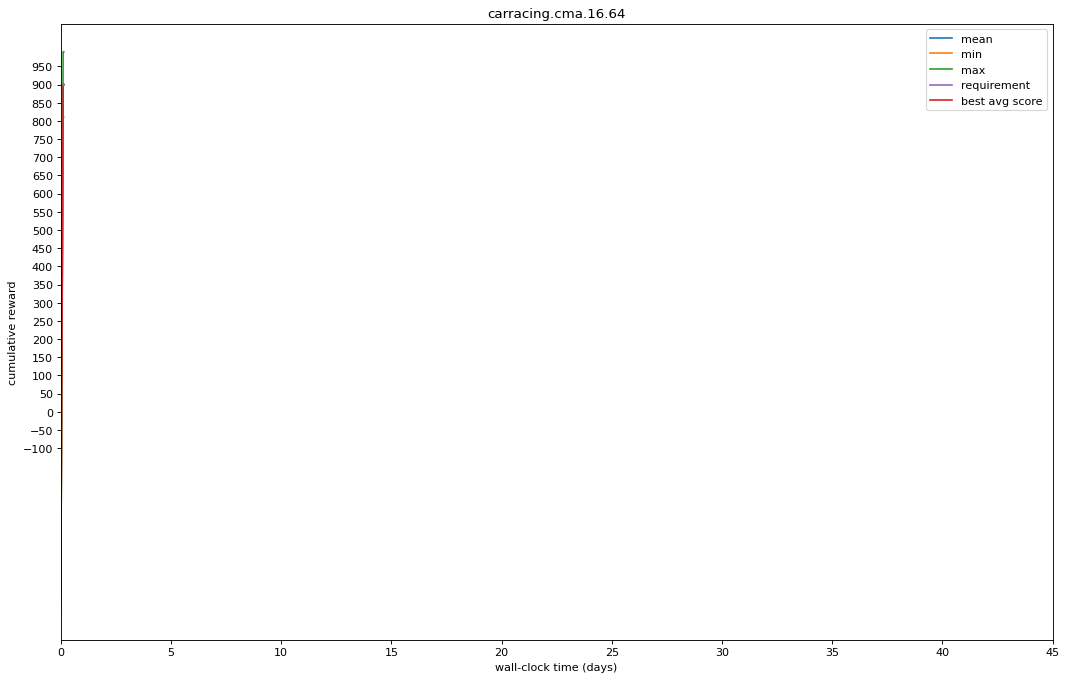

In [7]:
fig=plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
line_mean, = plt.plot(data[:, 1]/(60*24*60), data[:, 2])
line_min, = plt.plot(data[:, 1]/(60*24*60), data[:, 3])
line_max, = plt.plot(data[:, 1]/(60*24*60), data[:, 4])
line_best, = plt.plot(best_data[:, 1]/(60*24*60), best_data[:, 2])
line_req, = plt.plot(best_data[:, 1]/(60*24*60), best_data[:, 4])
plt.legend([line_mean, line_min, line_max, line_req, line_best], ['mean', 'min', 'max', 'requirement', 'best avg score'])
plt.xlabel('wall-clock time (days)')
plt.xticks(np.arange(0, 48, 5))
plt.ylabel('cumulative reward')
plt.yticks(np.arange(-100, 1000, 50))
plt.title(file_base)
plt.savefig(file_base+".wall.svg")
plt.show()

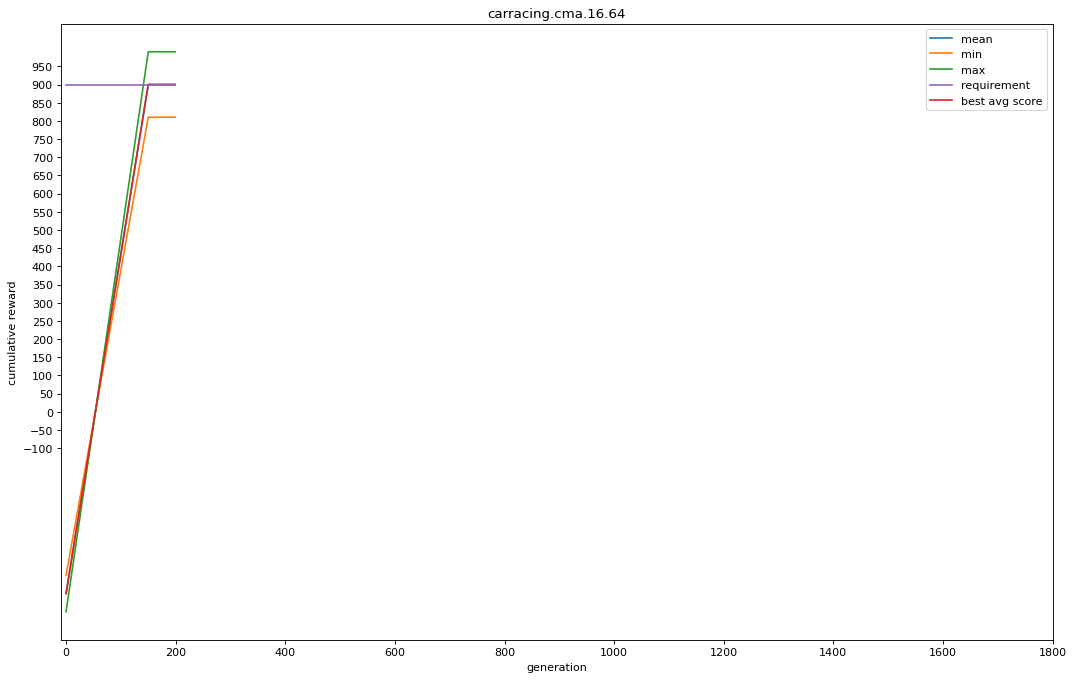

In [8]:
fig=plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
line_mean, = plt.plot(data[:, 0], data[:, 2])
line_min, = plt.plot(data[:, 0], data[:, 3])
line_max, = plt.plot(data[:, 0], data[:, 4])
line_best, = plt.plot(best_data[:, 0], best_data[:, 2])
line_req, = plt.plot(best_data[:, 0], best_data[:, 4])
plt.legend([line_mean, line_min, line_max, line_req, line_best], ['mean', 'min', 'max', 'requirement', 'best avg score'])
plt.xlabel('generation')
plt.xticks(np.arange(0, 2000, 200))
plt.ylabel('cumulative reward')
plt.yticks(np.arange(-100, 1000, 50))
plt.title(file_base)
plt.savefig(file_base+".svg")
plt.show()